![Logo_Seattle](Seattle_logo.jpg)

# **Projet 4 - <span style="color:#1d479b">Anticipez les besoins en consommation de bâtiments</span>**
---

**<span style="color:#1d479b">Rappel de l'objectif de la mission:</span>**
* Tenter de **prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.
* **Evaluer l’intérêt de l’"ENERGY STAR Score"** pour la prédiction d’émissions.

**<span style="color:#1d479b">Objectif du notebook:</span>** Réaliser une EDA en vue d'obtenir un jeu de données contenant des informations pertinentes pour répondre aux objectifs de la mission.

**Notebook EDA:**

1. Pre-Processing
   objectif: tranformer le data set pour le mettre dans un format propice au ML
   
   CHECKLIST:
   * création du Train set / Test set
   * elimination des NaN
   * Encodage
   * supression des outliers néfastes au modèle
   * feature selection
   * feature engineering
   * feature scaling
2. Modelling
   objectif: développer un modèle de ML
   
   CHECKLIST:
   * définir une fonction d'évaluation
   * entrainement de différents modèles
   * optimisation avec gridsearchcv
   * analyse des erreurs et retour au Preprocessing/EDA
   * learning curve et prise de décision

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#scikit-learn
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import shap
from shap.models import TransformersPipeline

import os
import glob

In [2]:
data_finale = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/2016_Building_Energy_Nettoyage_Final.csv"
df_f = pd.read_csv(data_finale, sep=",")
df = df_f.copy()

In [3]:
# Définie les options d'affichage pour les lignes et colonnes
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',80)
# Supprime les warnings (pour le ridge)
"""import warnings
warnings.filterwarnings('ignore')"""

plt.rcParams['axes.titlesize'] = 16  # Taille du titre
plt.rcParams['axes.titlecolor'] = '#000'  # Couleur du titre
plt.rcParams['axes.titlepad'] = 20  # Espace sous le titre du titre

plt.rcParams['axes.labelsize'] = 10  # Taille des labels des axes
plt.rcParams['axes.labelcolor'] = '#000'  # Couleur des labels des axes

plt.rcParams['xtick.labelsize'] = 8  # Taille des labels des ticks x
plt.rcParams['ytick.labelsize'] = 8  # Taille des labels des ticks y
plt.rcParams['xtick.color'] = '#333'  # Couleur des labels des ticks x
plt.rcParams['ytick.color'] = '#333'  # Couleur des labels des ticks y

In [4]:
# deleted columns
df = df_f.drop(columns=["Unnamed: 0","Latitude","Longitude","ENERGYSTARScore","TotalGHGEmissions"])

In [5]:
df.isna().mean().sort_values(ascending=False).head(5)

ThirdLargestPropertyUseType        0.774685
ThirdLargestPropertyUseTypeGFA     0.774685
SecondLargestPropertyUseType       0.451292
SecondLargestPropertyUseTypeGFA    0.451292
Neighborhood                       0.000000
dtype: float64

In [6]:
def imputation(df):
    other_use_type = ["SecondLargestPropertyUseType","SecondLargestPropertyUseTypeGFA",
                      "ThirdLargestPropertyUseType","ThirdLargestPropertyUseTypeGFA"]
    df = df.drop(columns=other_use_type)

    # df["Neighborhood"] = df["Neighborhood"].str.upper().replace('DELRIDGE NEIGHBORHOODS',"DELRIDGE")

    print("Imputation OK!")

    return df

In [7]:
def encodage(df):

    categorical_cols = list(df.select_dtypes(include="object").columns)
    numerical_cols = list(df.select_dtypes(include=["int","float"]).columns)
    numerical_cols.remove('SiteEnergyUseWN(kBtu)')

    # Create transformers for preprocessing
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

    print("Pipeline d'encodage OK!")

    return df, preprocessor

In [8]:
def preprocessing(df):

    df = imputation(df)
    df, preprocessor = encodage(df)

    X = df.drop(columns="SiteEnergyUseWN(kBtu)")
    y = df["SiteEnergyUseWN(kBtu)"]
    
    print("Preprocessing terminé !\n")
    
    return X, y, preprocessor

In [9]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
X_train, y_train, preprocessor = preprocessing(trainset)
X_test, y_test, preprocessor = preprocessing(testset)

Imputation OK!
Pipeline d'encodage OK!
Preprocessing terminé !

Imputation OK!
Pipeline d'encodage OK!
Preprocessing terminé !



In [11]:
# Définit les modèles
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor(),
    "SVR": SVR(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
}
# Définir les hyperparamètres pour chaque modèle
param_grid = {
    "RandomForest": {'model__n_estimators': [200],
                     'model__max_depth': [None, 10, 100],
                     'model__min_samples_leaf': [1, 2, 4]},
    "GradientBoosting": {'model__n_estimators': [200, 300],
                         'model__max_depth': [None, 10, 100],
                         'model__min_samples_leaf': [11, 12, 13]},
    "KNeighbors": {'model__n_neighbors': list(range(1, 10))},
    "SVR": {'model__C': [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]},
    "Ridge": {'model__alpha': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]},
    "Lasso": {'model__alpha': [1e1, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]}
}

In [12]:
# Define a function to add line breaks
def add_line_breaks(label):
    return str(label).replace(",", ",\n")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


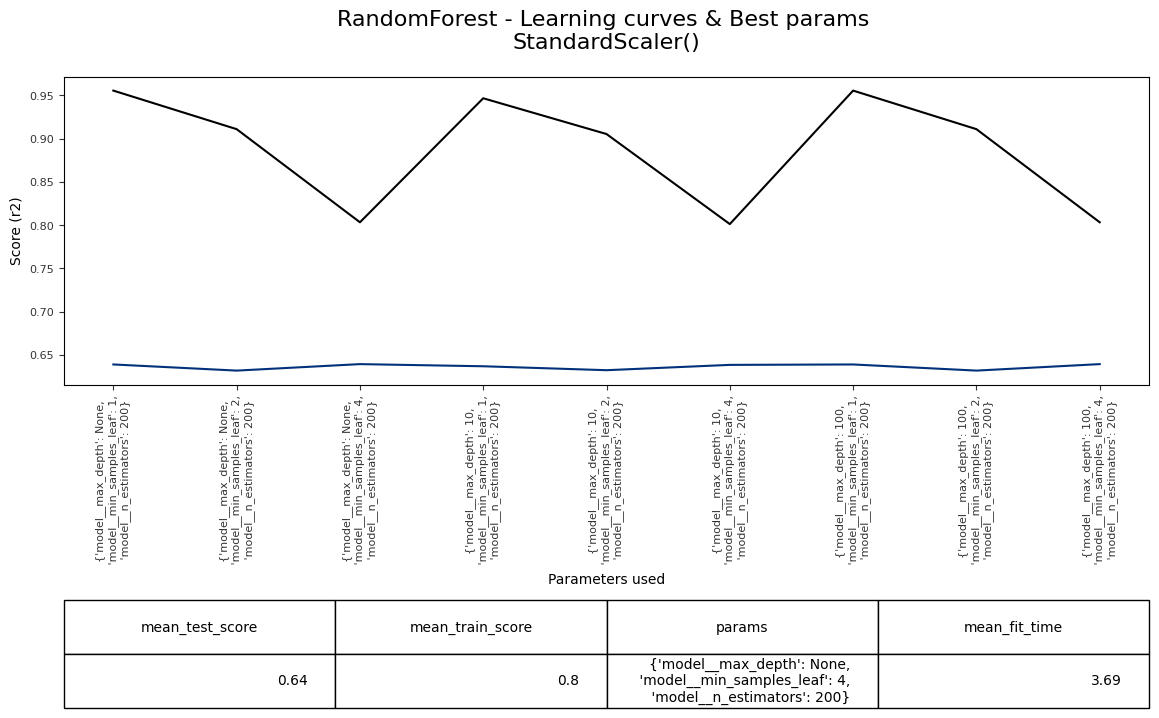

Fitting 5 folds for each of 18 candidates, totalling 90 fits


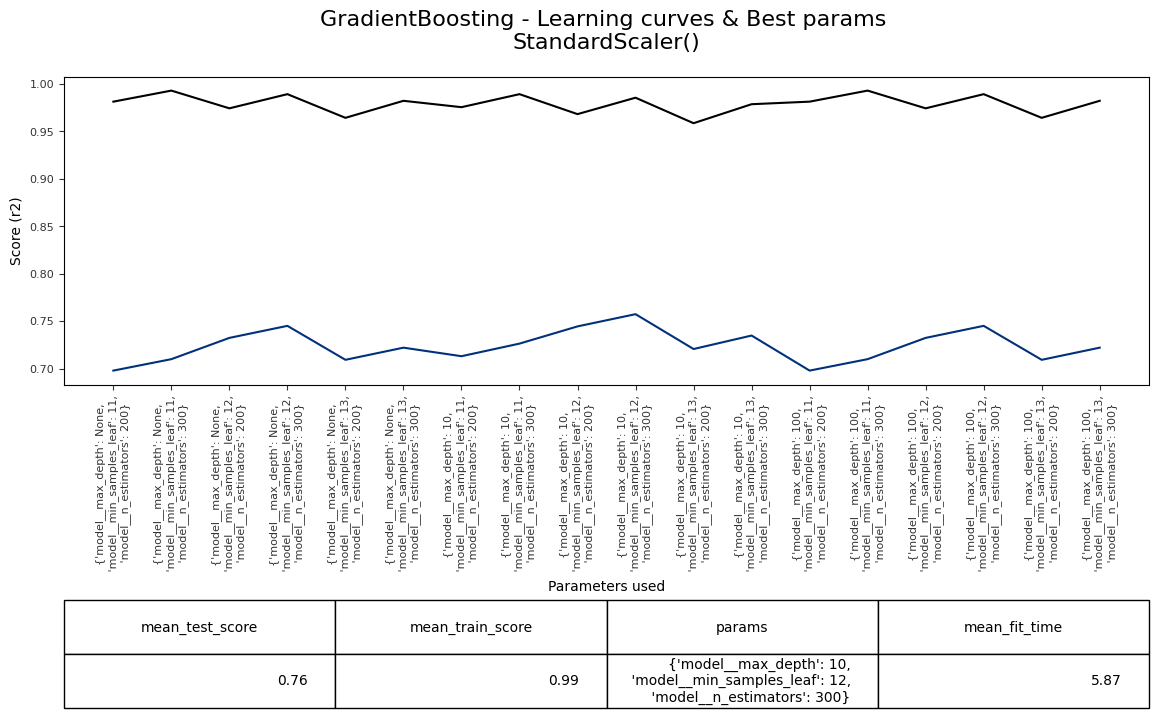

Fitting 5 folds for each of 9 candidates, totalling 45 fits


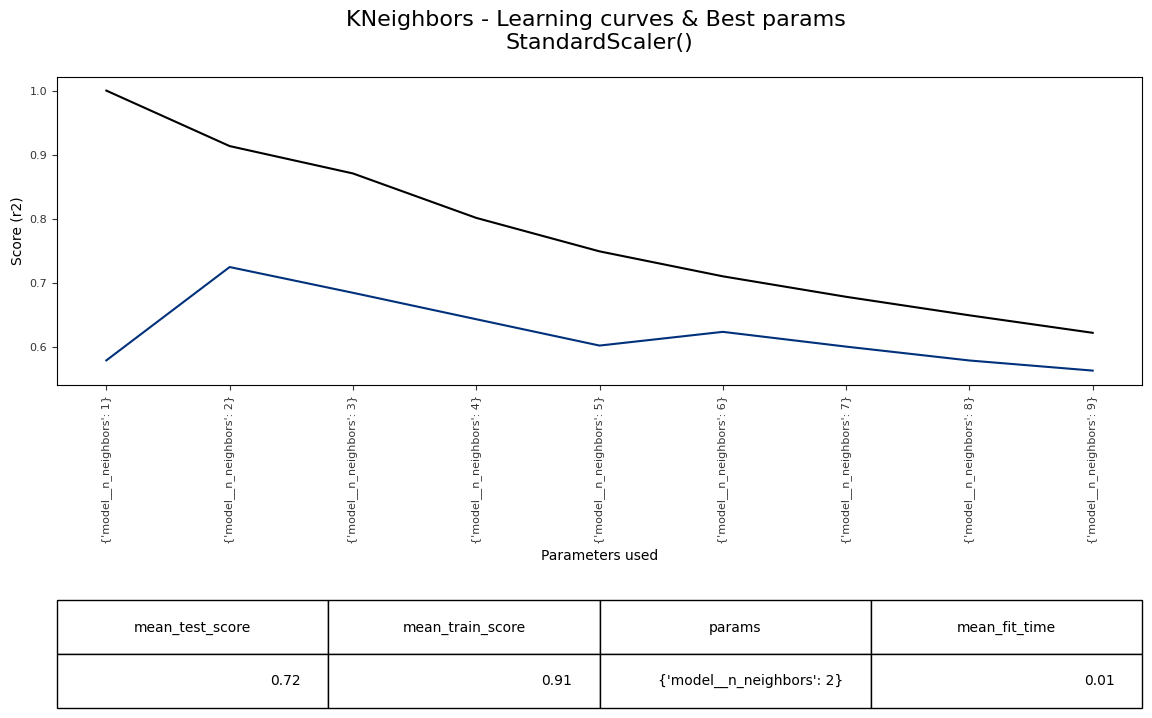

Fitting 5 folds for each of 8 candidates, totalling 40 fits


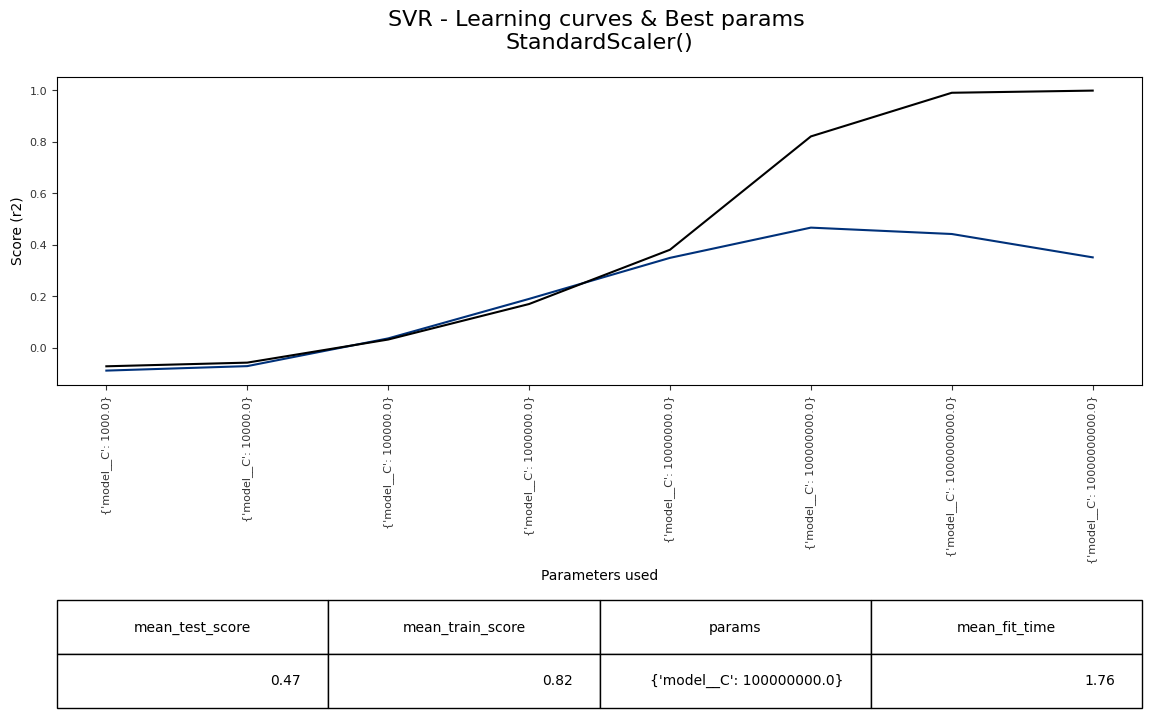

Fitting 5 folds for each of 9 candidates, totalling 45 fits


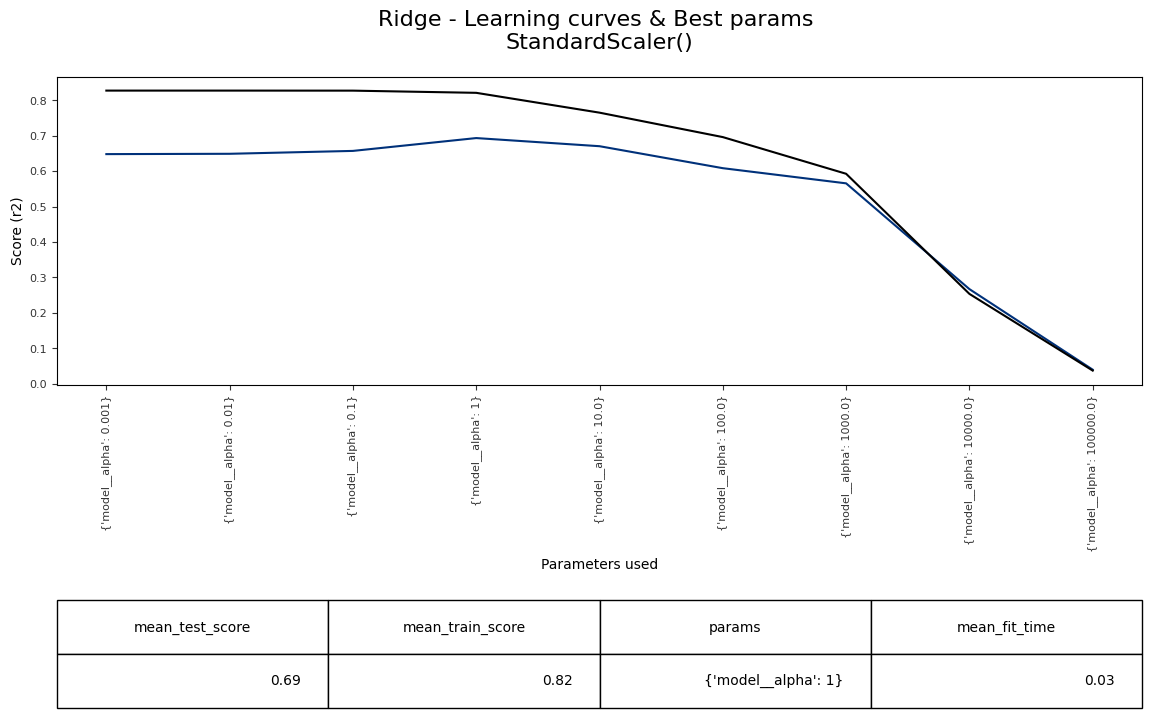

Fitting 5 folds for each of 7 candidates, totalling 35 fits


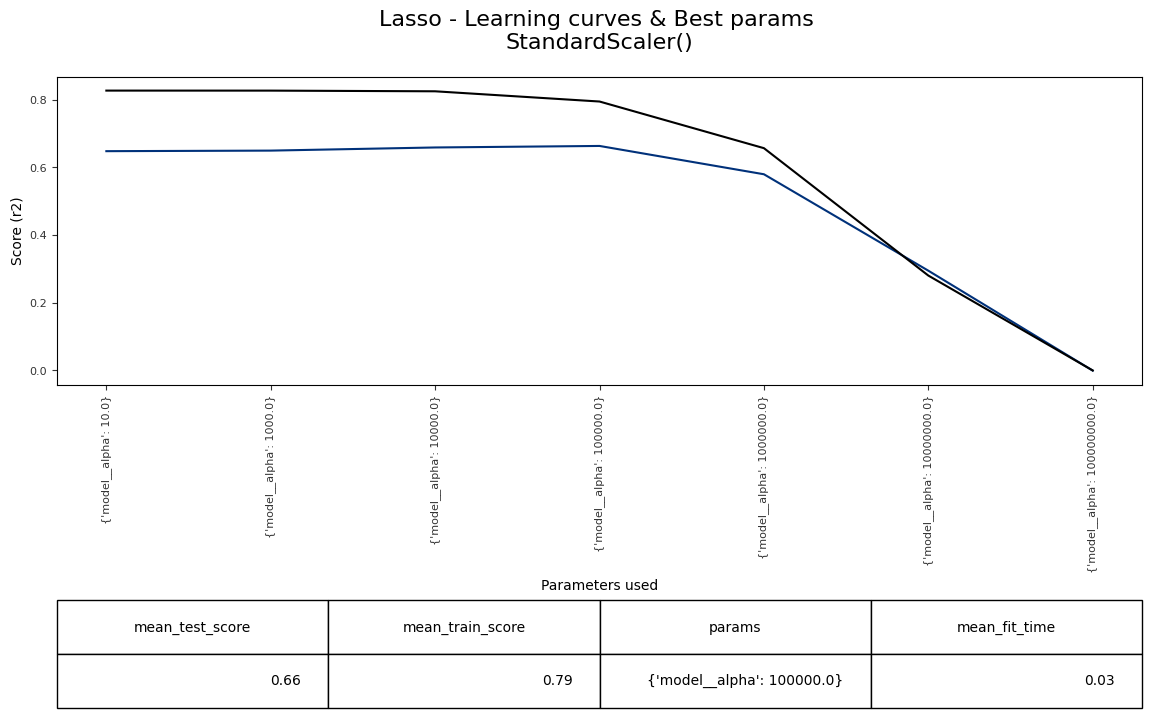

In [13]:
from joblib import dump

# Create an empty DataFrame to store the results
results_df = pd.DataFrame()

# Bouclez sur chaque modèle dans le dictionnaire 'models'
for name, model in models.items():

    # Create the final pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    # Définir la grille de recherche
    grid_search = GridSearchCV(pipeline, param_grid[name], cv=kfold, scoring='r2', return_train_score=True, n_jobs=-1, verbose=1)
    # Entraîner le modèle
    grid_search.fit(X_train, y_train)
    
    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    result = pd.DataFrame(grid_search.cv_results_)
    best_score = result.loc[result["rank_test_score"] == 1][["mean_test_score","mean_train_score","params","mean_fit_time"]].head(1)
    # Apply the function to the 'params' column in 'best_score'
    best_score["params"] = best_score["params"].apply(add_line_breaks)
    best_score[["mean_test_score","mean_train_score","mean_fit_time"]] = best_score[["mean_test_score","mean_train_score","mean_fit_time"]].round(2)
    
    # Crée un nouveau df
    result_score = best_score.copy()
    # Ajoute une colonne pour le nom du modèle
    result_score['model_name'] = result_score['model_name'] = name
    # Append the best_score DataFrame to the results_df DataFrame
    results_df = pd.concat([results_df, result_score])
    
    # Define x-axis ticks and labels
    x_ticks = range(len(result["mean_test_score"]))
    labels = [str(label).replace(",", ",\n") for label in result["params"].tolist()]

    plt.figure(figsize=(14,4))
    plt.plot(result["mean_test_score"], color="#00317A")
    plt.plot(result["mean_train_score"], color="#000")
    # Ajoutez un tableau avec les données de 'results' sous l'image
    table = plt.table(cellText=best_score.values,
                    colLabels=best_score.columns,
                    loc='bottom', 
                    bbox=[0, -1.05, 1, 0.35])  # ajustez ces valeurs pour déplacer le tableau
    table.auto_set_font_size(False)
    plt.title(f"{name} - Learning curves & Best params \nStandardScaler()")
    plt.ylabel("Score (r2)")
    plt.xlabel("Parameters used")
    plt.xticks(x_ticks, labels, rotation=90)  # Add x-axis labels
    # Créez le nom du fichier avec le nouveau numéro
    filename = f"./P4_ResultsModels/{name}_test_model_StandardScaler.jpeg"
    # Enregistrez le graphique dans le fichier
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

In [14]:
results_df.set_index("model_name", inplace=True)

In [15]:
results_df = results_df.sort_values(by="mean_test_score", ascending=False).reset_index()
results_df.to_csv(f"./P4_ResultsModels/best_score_model_StandardScaler').csv", sep=";")
results_df

,model_name,mean_test_score,mean_train_score,params,mean_fit_time
0,GradientBoosting,0.76,0.99,"{'model__max_depth': 10,\n 'model__min_samples...",5.87
1,KNeighbors,0.72,0.91,{'model__n_neighbors': 2},0.01
2,Ridge,0.69,0.82,{'model__alpha': 1},0.03
3,Lasso,0.66,0.79,{'model__alpha': 100000.0},0.03
4,RandomForest,0.64,0.80,"{'model__max_depth': None,\n 'model__min_sampl...",3.69
5,SVR,0.47,0.82,{'model__C': 100000000.0},1.76


In [16]:
results_df.loc[results_df["mean_test_score"].idxmax()]["params"].replace("\n", "")

"{'model__max_depth': 10, 'model__min_samples_leaf': 12, 'model__n_estimators': 300}"

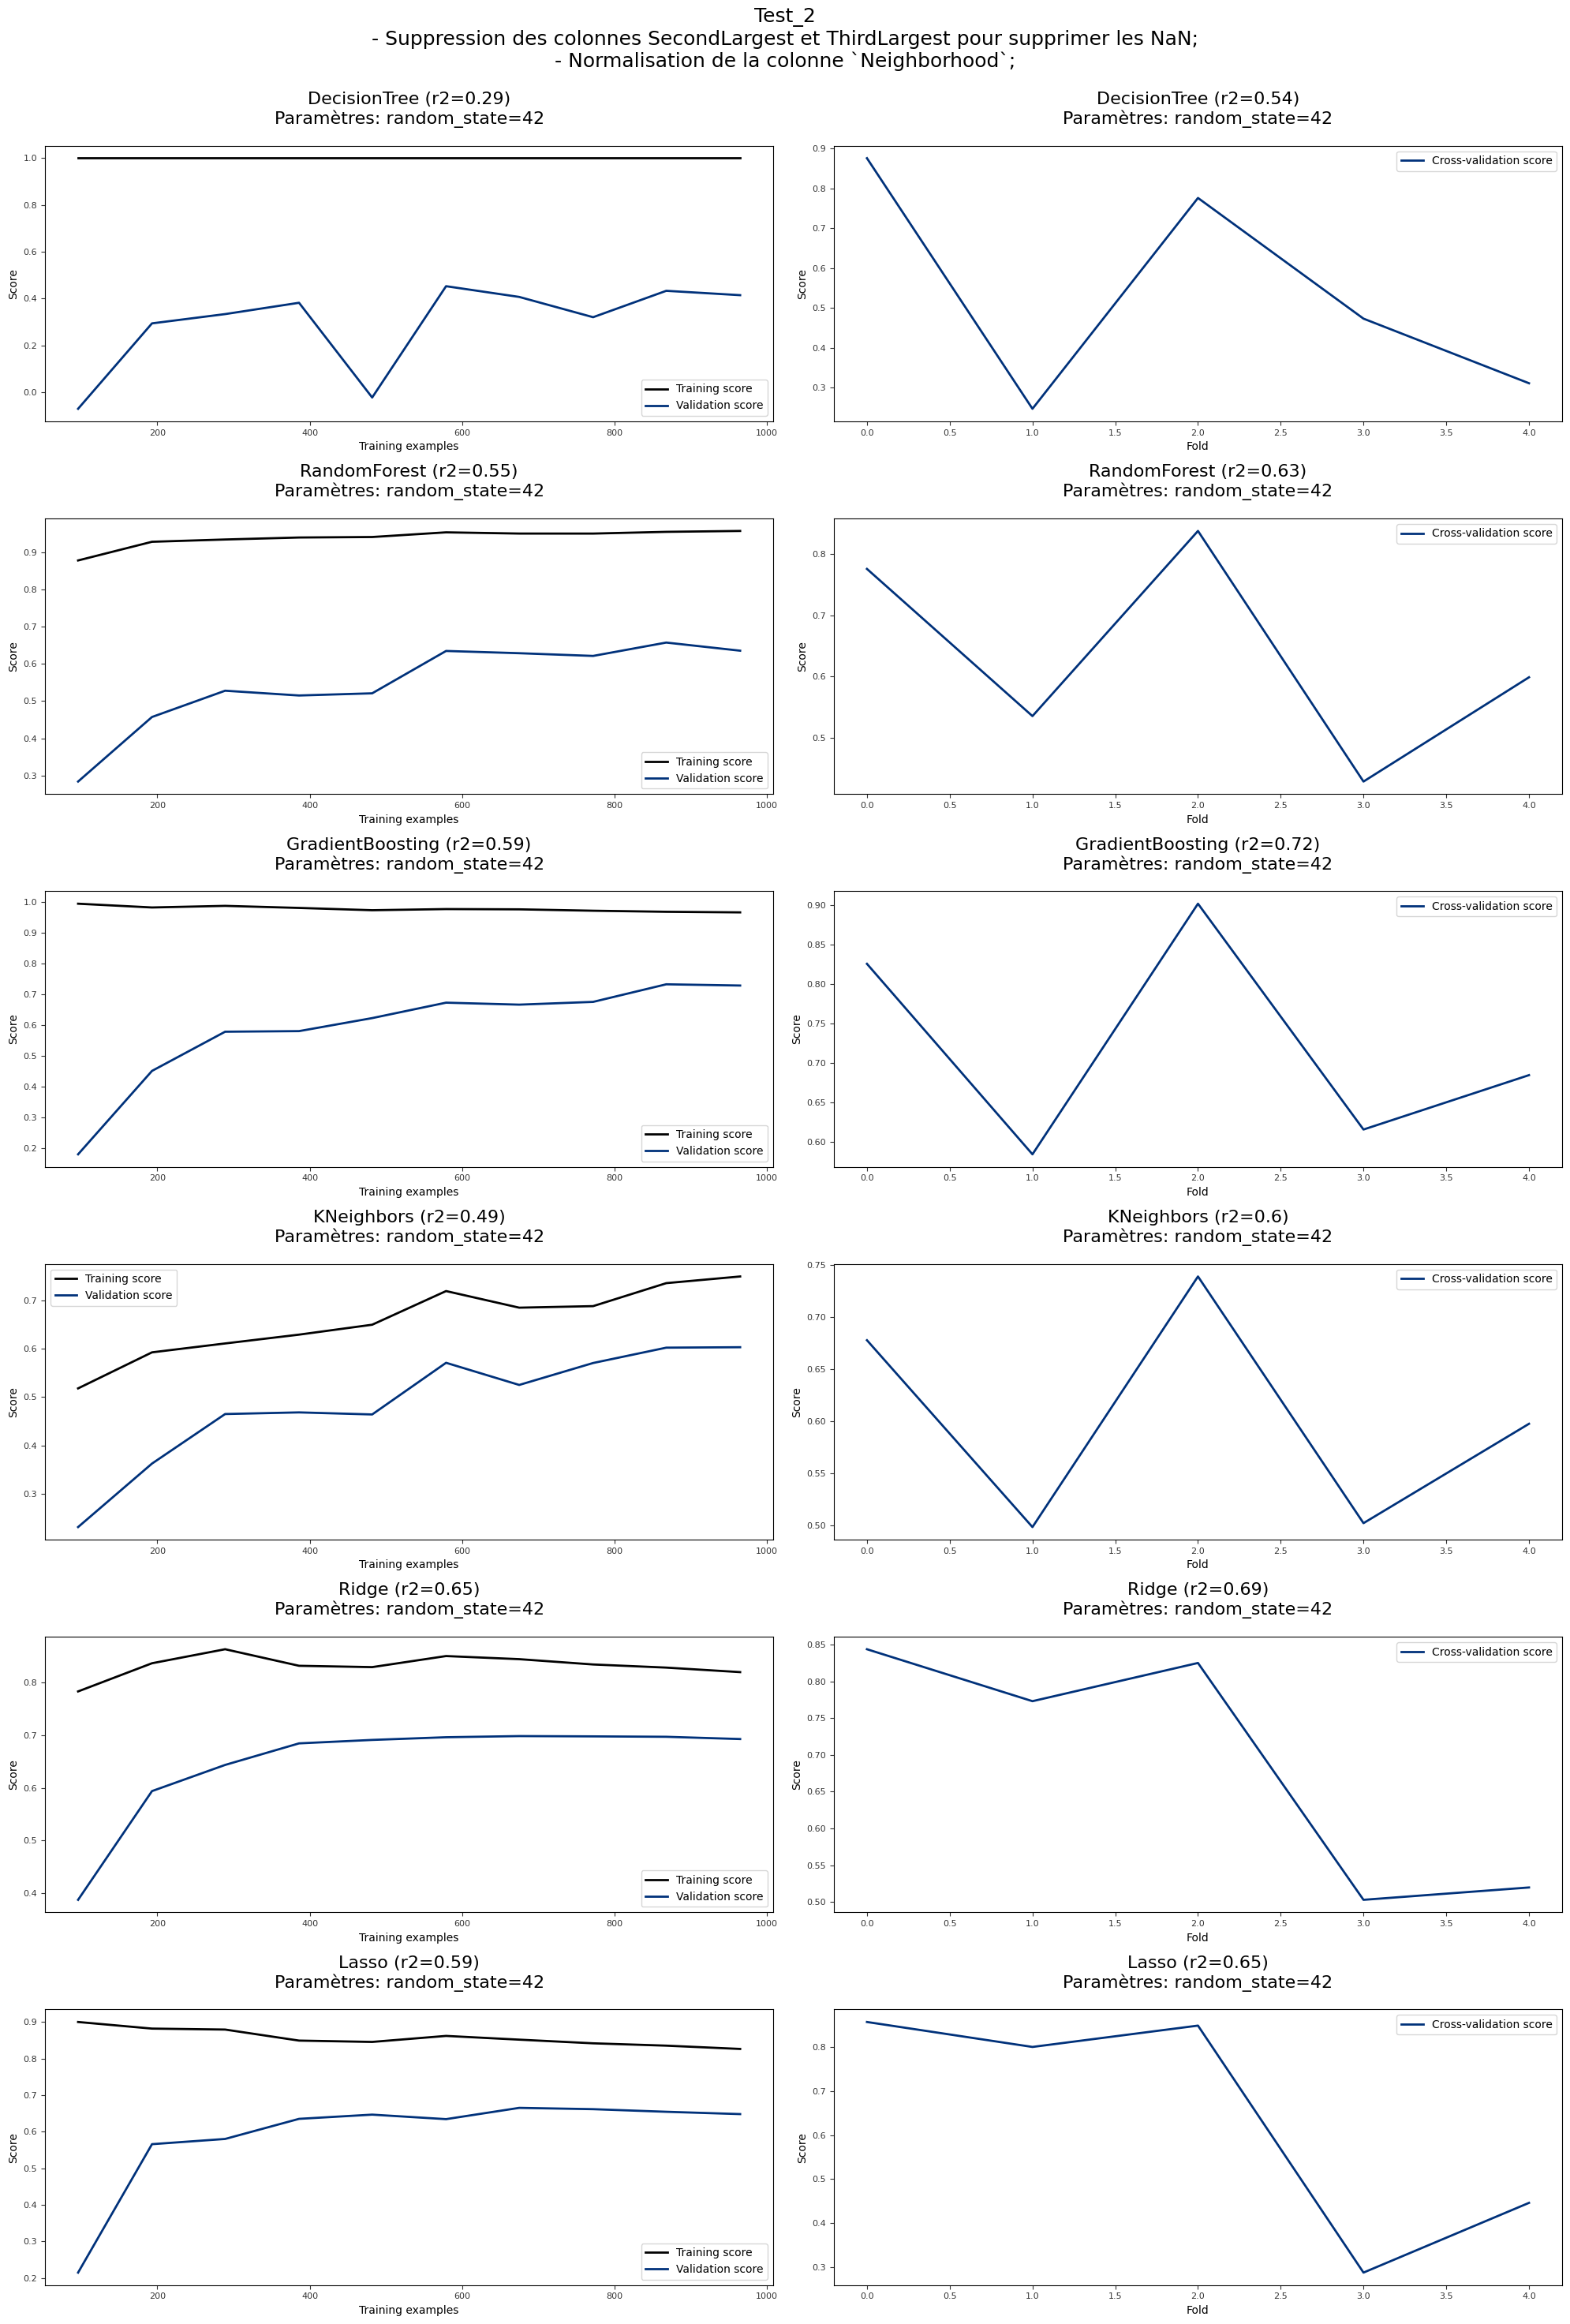

In [14]:
# Obtenez une liste de tous les fichiers qui correspondent au motif "Test_*.jpeg"
files = glob.glob("./P4_ResultsModels/Test_*.jpeg")

# Triez cette liste en fonction du numéro dans le nom du fichier
files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Prenez le dernier élément de la liste, extrayez le numéro du fichier à partir de son nom, et incrémentez-le
if files:
    last_file_num = int(files[-1].split("_")[-1].split(".")[0]) + 1
else:
    last_file_num = 1
    
# Define number of subplots per line
n_plots_per_row = 2
# Détail sur le test effectué
commentaire = f"""- Suppression des colonnes SecondLargest et ThirdLargest pour supprimer les NaN;
- Normalisation de la colonne `Neighborhood`;"""

# Create a figure with several subplots
fig, axes = plt.subplots(nrows=len(models), ncols=n_plots_per_row, figsize=(20, 5*len(models)))
# Add a unique title for each target
plt.suptitle(f"Test_{last_file_num}\n{commentaire}\n\n", color="#000", fontsize=18)

# Bouclez sur chaque modèle dans le dictionnaire 'models'
for i, (name, model) in enumerate(models.items()):
    # Créez le pipeline final
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Entraînez le modèle
    pipeline.fit(X_train, y_train)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Obtenez les courbes d'apprentissage
    N, train_scores, val_scores = learning_curve(pipeline, X_train, y_train, cv=kfold, scoring='r2', train_sizes=np.linspace(0.1, 1, 10))
    
    # Obtenez les scores de validation croisée
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
    
    # Create a bar graph in the left subplot
    ax = axes[i, 0]    
    # Tracez les courbes d'apprentissage sur le premier graphique
    ax.plot(N, train_scores.mean(axis=1), label='Training score', color="#000", linewidth=2)
    ax.plot(N, val_scores.mean(axis=1), label='Validation score', color="#00317a", linewidth=2)
    ax.set_title(f"{name} (r2={round(val_scores.mean(),2)})\nParamètres: random_state=42")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

    # Create a bar graph in the right subplot
    ax = axes[i, 1]
    # Tracez les scores de validation croisée sur le deuxième graphique
    ax.plot(scores, label='Cross-validation score', color="#00317a", linewidth=2)
    ax.set_title(f"{name} (r2={round(scores.mean(),2)})\nParamètres: random_state=42")
    ax.set_xlabel("Fold")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

# Automatically adjust margins to avoid overlapping subplots
plt.tight_layout()
# Créez le nom du fichier avec le nouveau numéro
filename = f"./P4_ResultsModels/Test_{last_file_num}.jpeg"
# Enregistrez le graphique dans le fichier
plt.savefig(filename) 
# Display figure   
plt.show()

# Brouillon

In [ ]:
# Bouclez sur chaque modèle dans le dictionnaire 'models'
for name, model in models.items():
    # Créez le pipeline final
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    
    # Entraînez le modèle
    pipeline.fit(X_train, y_train)
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)

    # Obtenez les courbes d'apprentissage
    N, train_scores, valt_scores = learning_curve(pipeline, X_train, y_train, cv=kfold, scoring='r2', train_sizes=np.linspace(0.1, 1, 10))
    
    # Tracez les courbes d'apprentissage
    plt.plot(N, train_scores.mean(axis=1), label='Training score')
    plt.plot(N, valt_scores.mean(axis=1), label='Validation score')
    plt.title(f"Modèle: {name}\nScore r2: {valt_scores.mean()}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

In [ ]:
# Bouclez sur chaque modèle dans le dictionnaire 'models'
for name, model in models.items():
   # Créez le pipeline final
   pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', model)])
   
   # Entraînez le modèle
   pipeline.fit(X_train, y_train)
   
   kfold = KFold(n_splits=5, shuffle=True, random_state=42)

   # Obtenez les scores de validation croisée
   scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
   
   # Tracez les scores de validation croisée
   plt.plot(scores, label='Cross-validation score')
   plt.title(f"Modèle: {name}\nScore r2: {scores.mean()}")
   plt.xlabel("Fold")
   plt.ylabel("Score")
   plt.legend(loc="best")
   plt.show()

* Faire la même chose avec ENERGYScore.

* Faire SHAP pour les 2 méthodes pour étudier l'importance des variables (uniquement sur le meilleur modèle).
feature_importance (local)

* Dans la pipeline, utiliser un powertransformer (choisi la meilleure transformation) à la place du standard scaler.